In [1]:
# See: https://github.com/adamkarvonen/SAEBench/blob/main/sae_bench_demo.ipynb

In [ ]:
import os

import torch

import sae_bench.custom_saes.custom_sae_config as custom_sae_config
import sae_bench.custom_saes.relu_sae as relu_sae
import sae_bench.custom_saes.run_all_evals_custom_saes as run_all_evals_custom_saes
import sae_bench.evals.core.main as core
import sae_bench.evals.sparse_probing.main as sparse_probing
import sae_bench.sae_bench_utils.general_utils as general_utils
from sae_bench.sae_bench_utils.sae_selection_utils import get_saes_from_regex

In [ ]:
RANDOM_SEED = 42

output_folders = {
    "absorption": "eval_results/absorption",
    "autointerp": "eval_results/autointerp",
    "core": "eval_results/core",
    "scr": "eval_results/scr",
    "tpp": "eval_results/tpp",
    "sparse_probing": "eval_results/sparse_probing",
    "unlearning": "eval_results/unlearning",
}

# Note: Unlearning is not recommended for models with < 2B parameters and we recommend an instruct tuned model
# Unlearning will also require requesting permission for the WMDP dataset (see unlearning/README.md)
# Absorption not recommended for models < 2B parameters
# asyncio doesn't like notebooks, so autointerp must be ran using a python script

# Select your eval types here.
eval_types = [
    "absorption",
    # "autointerp",
    "core",
    "scr",
    "tpp",
    "sparse_probing",
    # "unlearning",
]

if "autointerp" in eval_types:
    raise ValueError("autointerp must be ran using a python script")

device = general_utils.setup_environment()

model_name = "pythia-70m-deduped"
llm_batch_size = 512
torch_dtype = torch.float32

# Currently all evals take str_dtype instead of torch_dtype. We did this for serialization purposes, but it was probably a mistake.
# For now we will just use the str_dtype. TODO: Fix this
str_dtype = torch_dtype.__str__().split(".")[-1]


# If evaluating multiple SAEs on the same layer, set save_activations to True
# This will require at least 100GB of disk space
save_activations = False

In [ ]:
repo_id = "canrager/lm_sae"
baseline_filename = (
    "pythia70m_sweep_standard_ctx128_0712/resid_post_layer_4/trainer_8/ae.pt"
)
hook_layer = 4
hook_name = f"blocks.{hook_layer}.hook_resid_post"

sae = relu_sae.load_dictionary_learning_relu_sae(
    repo_id, baseline_filename, model_name, device, torch_dtype, layer=hook_layer
)

print(f"sae dtype: {sae.dtype}, device: {sae.device}")

d_sae, d_in = sae.W_dec.data.shape

assert d_sae >= d_in

print(f"d_in: {d_in}, d_sae: {d_sae}")

In [5]:
sae.cfg = custom_sae_config.CustomSAEConfig(
    model_name, d_in=d_in, d_sae=d_sae, hook_name=hook_name, hook_layer=hook_layer
)

# Core evals require us to specify cfg.dtype, which must be a string for easy serialization. TODO: Refactor to use torch.dtype
sae.cfg.dtype = str_dtype


# The following contains our current defined SAE types and the shapes to plot for each. Add your custom SAE as new_sae_key
new_sae_key = "vanilla"
trainer_markers = {
    "standard": "o",
    "jumprelu": "X",
    "topk": "^",
    "p_anneal": "*",
    "gated": "d",
    new_sae_key: "s",  # New SAE
}

trainer_colors = {
    "standard": "blue",
    "jumprelu": "orange",
    "topk": "green",
    "p_anneal": "red",
    "gated": "purple",
    new_sae_key: "black",  # New SAE
}

sae.cfg.architecture = new_sae_key
sae.cfg.training_tokens = 200_000_000

In [ ]:
# Note: the custom_sae_id should be unique, as it is used for the intermediate results and final results file names

unique_custom_sae_id = baseline_filename.replace("/", "_").replace(".", "_")
print(f"sae_id: {unique_custom_sae_id}")

# list of tuple of (sae_id, sae object)
custom_saes = [(unique_custom_sae_id, sae)]

In [ ]:
sae_regex_pattern = r"(sae_bench_pythia70m_sweep_topk_ctx128_0730).*"
sae_block_pattern = r".*blocks\.([4])\.hook_resid_post__trainer_(8)$"

baseline_saes = get_saes_from_regex(sae_regex_pattern, sae_block_pattern)
print(f"baseline_saes: {baseline_saes}")
baseline_sae_id = f"{baseline_saes[0][0]}_{baseline_saes[0][1]}".replace(".", "_")
print(f"baseline_sae_id: {baseline_sae_id}")

selected_saes = custom_saes + baseline_saes

In [ ]:
# Note: We typically run with n_eval_sparsity_variance_batches=2000, but I have reduced it here for a faster run

_ = core.multiple_evals(
    selected_saes=selected_saes,
    n_eval_reconstruction_batches=200,
    n_eval_sparsity_variance_batches=200,
    eval_batch_size_prompts=32,
    compute_featurewise_density_statistics=True,
    compute_featurewise_weight_based_metrics=True,
    exclude_special_tokens_from_reconstruction=True,
    dataset="Skylion007/openwebtext",
    context_size=128,
    output_folder="eval_results/core",
    verbose=True,
    dtype=str_dtype,
)

In [ ]:
# We do a subset of the sparse probing datasets here for shorter runtime
dataset_names = ["LabHC/bias_in_bios_class_set1"]

# TODO: Add a verbose flag
_ = sparse_probing.run_eval(
    sparse_probing.SparseProbingEvalConfig(
        model_name=model_name,
        random_seed=RANDOM_SEED,
        llm_batch_size=llm_batch_size,
        llm_dtype=str_dtype,
        dataset_names=dataset_names,
    ),
    selected_saes,
    device,
    "eval_results/sparse_probing",
    force_rerun=False,
    clean_up_activations=True,
    save_activations=save_activations,
)

In [10]:
import json

import torch

import sae_bench.sae_bench_utils.graphing_utils as graphing_utils

In [11]:
image_path = "./images"

if not os.path.exists(image_path):
    os.makedirs(image_path)

In [ ]:
results_folders = ["./eval_results"]

eval_type = "sparse_probing"

eval_folders = []
core_folders = []
for results_folder in results_folders:
    eval_folders.append(f"{results_folder}/{eval_type}")
    core_folders.append(f"{results_folder}/core")

eval_filenames = graphing_utils.find_eval_results_files(eval_folders)
core_filenames = graphing_utils.find_eval_results_files(core_folders)

print(f"eval_filenames: {eval_filenames}")
print(f"core_filenames: {core_filenames}")

In [ ]:
eval_results_dict = graphing_utils.get_eval_results(eval_filenames)
core_results_dict = graphing_utils.get_eval_results(core_filenames)

for sae in eval_results_dict:
    eval_results_dict[sae].update(core_results_dict[sae])


print(eval_results_dict.keys())

In [ ]:
baseline_filepath = eval_filenames[0]

with open(baseline_filepath) as f:
    baseline_sae_eval_results = json.load(f)

custom_filepath = eval_filenames[1]

with open(custom_filepath) as f:
    custom_sae_eval_results = json.load(f)

k = 1

print(baseline_sae_eval_results.keys())

print(
    f"Baseline SAE top {k} accuracy was:",
    baseline_sae_eval_results["eval_result_metrics"]["sae"][
        f"sae_top_{k}_test_accuracy"
    ],
)
print(
    f"Custom SAE top {k} accuracy was:",
    custom_sae_eval_results["eval_result_metrics"]["sae"][f"sae_top_{k}_test_accuracy"],
)
print(
    f"LLM residual stream top {k} accuracy was:",
    baseline_sae_eval_results["eval_result_metrics"]["llm"][
        f"llm_top_{k}_test_accuracy"
    ],
)

In [ ]:
image_base_name = os.path.join(image_path, "sparse_probing")

graphing_utils.plot_results(
    eval_filenames,
    core_filenames,
    eval_type,
    image_base_name,
    k,
    trainer_markers=trainer_markers,
    trainer_colors=trainer_colors,
)

In [16]:
_ = run_all_evals_custom_saes.run_evals(
    model_name,
    selected_saes,
    llm_batch_size,
    str_dtype,
    device,
    eval_types,
    api_key=None,
    force_rerun=False,
    save_activations=save_activations,
)

















training k-probes: 100%|██████████| 260/260 [00:53<00:00,  4.84it/s]

Loading validation data


Evaluating raw k-sparse probing scores














































































































































































































































































































100%|██████████| 8659/8659 [00:32<00:00, 265.52it/s]


Building metadata
























100%|██████████| 26/26 [00:06<00:00,  4.03it/s]


Loading probe and training data
Training k-sparse probes


Loading validation data


Evaluating raw k-sparse probing scores

















































































































































































































































































































100%|██████████| 8659/8659 [00:33<00:00, 260.14it/s]


Building metadata
























Evaluations:  20%|██        | 1/5 [05:52<23:30, 352.59s/it]




Running core evaluation





Evaluations:  40%|████      | 2/5 [05:52<07:15, 145.29s/it]

Skipping pythia70m_sweep_standard_ctx128_0712_resid_post_layer_4_trainer_8_ae_pt_custom_sae as results already exist
Skipping sae_bench_pythia70m_sweep_topk_ctx128_0730_blocks.4.hook_resid_post__trainer_8 as results already exist



Running scr evaluation



Loaded pretrained model pythia-70m-deduped into HookedTransformer









Tokenizing data: 100%|██████████| 6/6 [00:00<00:00,  7.95it/s]



Tokenizing data: 100%|██████████| 6/6 [00:00<00:00, 27.25it/s]









































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male / female: 0.9950000643730164
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_data_only: 0.9940000176429749
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for professor / nurse: 0.9440000653266907
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for nurse_data_only: 0.9420000314712524
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male_professor / female_nurse: 0.9960000514984131
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_nurse_data_only: 0.9960000514984131
dir: 1, original_acc: 0.6740000247955322, clean_acc: 0.9440000653266907, changed_acc: 0.83








Tokenizing data: 100%|██████████| 6/6 [00:00<00:00,  8.09it/s]



Tokenizing data: 100%|██████████| 6/6 [00:00<00:00, 28.46it/s]









































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male / female: 0.9860000610351562
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_data_only: 0.9860000610351562
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for professor / nurse: 0.9330000281333923
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for nurse_data_only: 0.9300000667572021
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male_professor / female_nurse: 0.9960000514984131
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_nurse_data_only: 0.9960000514984131
dir: 1, original_acc: 0.597000002861023, clean_acc: 0.9330000281333923, changed_acc: 0.758








Tokenizing data: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]



Tokenizing data: 100%|██████████| 6/6 [00:00<00:00, 27.46it/s]









































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male / female: 0.9810000658035278
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_data_only: 0.9810000658035278
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for professor / nurse: 0.9500000476837158
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for nurse_data_only: 0.9500000476837158
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male_professor / female_nurse: 0.999000072479248
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_nurse_data_only: 0.999000072479248
dir: 1, original_acc: 0.6810000538825989, clean_acc: 0.9500000476837158, changed_acc: 0.8160








Tokenizing data: 100%|██████████| 6/6 [00:00<00:00,  8.73it/s]


Tokenizing data: 100%|██████████| 6/6 [00:00<00:00, 32.10it/s]









































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male / female: 0.9920000433921814
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_data_only: 0.9920000433921814
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for professor / nurse: 0.9380000233650208
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for nurse_data_only: 0.9390000700950623
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male_professor / female_nurse: 0.999000072479248
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_nurse_data_only: 0.999000072479248
dir: 1, original_acc: 0.5740000009536743, clean_acc: 0.9380000233650208, changed_acc: 0.7570



























































Generating train split: 100%|██████████| 597682/597682 [00:02<00:00, 228120.09 examples/s]





Generating test split: 100%|██████████| 142500/142500 [00:00<00:00, 250630.81 examples/s]







Tokenizing data: 100%|██████████| 6/6 [00:00<00:00,  6.65it/s]



Tokenizing data: 100%|██████████| 6/6 [00:00<00:00, 23.83it/s]









































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male / female: 0.8110000491142273
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_data_only: 0.8110000491142273
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for professor / nurse: 0.987000048160553
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for nurse_data_only: 0.9860000610351562
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male_professor / female_nurse: 0.9810000658035278
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_nurse_data_only: 0.9820000529289246
dir: 1, original_acc: 0.8700000643730164, clean_acc: 0.987000048160553, changed_acc: 0.8710








Tokenizing data: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]



Tokenizing data: 100%|██████████| 6/6 [00:00<00:00, 23.39it/s]









































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male / female: 0.8060000538825989
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_data_only: 0.8060000538825989
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for professor / nurse: 0.9330000281333923
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for nurse_data_only: 0.9320000410079956
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male_professor / female_nurse: 0.9570000171661377
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_nurse_data_only: 0.9600000381469727
dir: 1, original_acc: 0.8330000638961792, clean_acc: 0.9330000281333923, changed_acc: 0.84








Tokenizing data: 100%|██████████| 6/6 [00:00<00:00,  6.94it/s]



Tokenizing data: 100%|██████████| 6/6 [00:00<00:00, 24.24it/s]









































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male / female: 0.8630000352859497
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_data_only: 0.8670000433921814
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for professor / nurse: 0.9520000219345093
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for nurse_data_only: 0.9540000557899475
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male_professor / female_nurse: 0.9750000238418579
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_nurse_data_only: 0.9760000705718994
dir: 1, original_acc: 0.8920000195503235, clean_acc: 0.9520000219345093, changed_acc: 0.88








Tokenizing data: 100%|██████████| 6/6 [00:00<00:00,  6.84it/s]



Tokenizing data: 100%|██████████| 6/6 [00:00<00:00, 11.93it/s]









































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male / female: 0.8350000381469727
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_data_only: 0.8380000591278076
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for professor / nurse: 0.8980000615119934
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for nurse_data_only: 0.8970000147819519
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male_professor / female_nurse: 0.9740000367164612
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_nurse_data_only: 0.9740000367164612
dir: 1, original_acc: 0.7820000648498535, clean_acc: 0.8980000615119934, changed_acc: 0.78








Tokenizing data: 100%|██████████| 6/6 [00:00<00:00,  8.39it/s]



Tokenizing data: 100%|██████████| 6/6 [00:00<00:00, 27.68it/s]









































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male / female: 0.9950000643730164
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_data_only: 0.9940000176429749
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for professor / nurse: 0.9440000653266907
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for nurse_data_only: 0.9420000314712524
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male_professor / female_nurse: 0.9960000514984131
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_nurse_data_only: 0.9960000514984131
dir: 1, original_acc: 0.6740000247955322, clean_acc: 0.9440000653266907, changed_acc: 0.84








Tokenizing data: 100%|██████████| 6/6 [00:00<00:00,  8.46it/s]


Tokenizing data: 100%|██████████| 6/6 [00:00<00:00, 29.69it/s]









































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male / female: 0.9860000610351562
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_data_only: 0.9860000610351562
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for professor / nurse: 0.9330000281333923
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for nurse_data_only: 0.9300000667572021
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male_professor / female_nurse: 0.9960000514984131
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_nurse_data_only: 0.9960000514984131
dir: 1, original_acc: 0.597000002861023, clean_acc: 0.9330000281333923, changed_acc: 0.836








Tokenizing data: 100%|██████████| 6/6 [00:00<00:00,  8.40it/s]


Tokenizing data: 100%|██████████| 6/6 [00:00<00:00, 29.94it/s]









































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male / female: 0.9810000658035278
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_data_only: 0.9810000658035278
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for professor / nurse: 0.9500000476837158
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for nurse_data_only: 0.9500000476837158
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male_professor / female_nurse: 0.999000072479248
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_nurse_data_only: 0.999000072479248
dir: 1, original_acc: 0.6810000538825989, clean_acc: 0.9500000476837158, changed_acc: 0.9140






Tokenizing data: 100%|██████████| 6/6 [00:00<00:00,  9.57it/s]


Tokenizing data: 100%|██████████| 6/6 [00:00<00:00, 34.33it/s]









































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male / female: 0.9920000433921814
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_data_only: 0.9920000433921814
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for professor / nurse: 0.9380000233650208
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for nurse_data_only: 0.9390000700950623
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male_professor / female_nurse: 0.999000072479248
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_nurse_data_only: 0.999000072479248
dir: 1, original_acc: 0.5740000009536743, clean_acc: 0.9380000233650208, changed_acc: 0.8610








Tokenizing data: 100%|██████████| 6/6 [00:00<00:00,  6.91it/s]



Tokenizing data: 100%|██████████| 6/6 [00:00<00:00, 24.44it/s]









































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male / female: 0.8110000491142273
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_data_only: 0.8110000491142273
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for professor / nurse: 0.987000048160553
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for nurse_data_only: 0.9860000610351562
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male_professor / female_nurse: 0.9810000658035278
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_nurse_data_only: 0.9820000529289246
dir: 1, original_acc: 0.8700000643730164, clean_acc: 0.987000048160553, changed_acc: 0.9100








Tokenizing data: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]



Tokenizing data: 100%|██████████| 6/6 [00:00<00:00, 25.29it/s]









































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male / female: 0.8060000538825989
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_data_only: 0.8060000538825989
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for professor / nurse: 0.9330000281333923
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for nurse_data_only: 0.9320000410079956
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male_professor / female_nurse: 0.9570000171661377
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_nurse_data_only: 0.9600000381469727
dir: 1, original_acc: 0.8330000638961792, clean_acc: 0.9330000281333923, changed_acc: 0.85








Tokenizing data: 100%|██████████| 6/6 [00:00<00:00,  7.05it/s]



Tokenizing data: 100%|██████████| 6/6 [00:00<00:00, 24.08it/s]









































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male / female: 0.8630000352859497
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_data_only: 0.8670000433921814
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for professor / nurse: 0.9520000219345093
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for nurse_data_only: 0.9540000557899475
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male_professor / female_nurse: 0.9750000238418579
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_nurse_data_only: 0.9760000705718994
dir: 1, original_acc: 0.8920000195503235, clean_acc: 0.9520000219345093, changed_acc: 0.89








Tokenizing data: 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]



Tokenizing data: 100%|██████████| 6/6 [00:00<00:00, 23.24it/s]









































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male / female: 0.8350000381469727
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_data_only: 0.8380000591278076
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for professor / nurse: 0.8980000615119934
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for nurse_data_only: 0.8970000147819519
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for male_professor / female_nurse: 0.9740000367164612
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for female_nurse_data_only: 0.9740000367164612
dir: 1, original_acc: 0.7820000648498535, clean_acc: 0.8980000615119934, changed_acc: 0.78

Evaluations:  60%|██████    | 3/5 [18:33<14:12, 426.28s/it]




Running tpp evaluation



Loaded pretrained model pythia-70m-deduped into HookedTransformer



100%|██████████| 28/28 [00:00<00:00, 597.53it/s]

100%|██████████| 28/28 [00:00<00:00, 947.05it/s]


Removing 24 from test set
Removing 12 from test set








Tokenizing data: 100%|██████████| 5/5 [00:00<00:00,  8.15it/s]


Tokenizing data: 100%|██████████| 5/5 [00:00<00:00, 30.03it/s]


































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 0: 0.8960000276565552
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 1: 0.9520000219345093
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 2: 0.9160000681877136
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 6: 0.9850000739097595
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 9: 0.9610000252723694



100%|██████████| 34/34 [00:00<00:00, 377.22it/s]

100%|██████████| 31/31 [00:00<00:00, 781.33it/s]


Removing 7 from train set
Removing 31 from train set
Removing 29 from train set
Removing 0 from train set
Removing 28 from train set








Tokenizing data: 100%|██████████| 5/5 [00:00<00:00,  6.32it/s]


Tokenizing data: 100%|██████████| 5/5 [00:00<00:00, 22.67it/s]


































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 1: 0.8810000419616699
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 2: 0.8690000176429749
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 3: 0.8670000433921814
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 5: 0.8440000414848328
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 6: 0.7700000405311584



100%|██████████| 28/28 [00:00<00:00, 434.82it/s]

100%|██████████| 28/28 [00:00<00:00, 957.58it/s]


Removing 24 from test set
Removing 12 from test set








Tokenizing data: 100%|██████████| 5/5 [00:00<00:00,  8.26it/s]


Tokenizing data: 100%|██████████| 5/5 [00:00<00:00, 30.68it/s]


































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 0: 0.8960000276565552
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 1: 0.9520000219345093
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 2: 0.9160000681877136
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 6: 0.9850000739097595
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 9: 0.9610000252723694



100%|██████████| 34/34 [00:00<00:00, 380.61it/s]

100%|██████████| 31/31 [00:00<00:00, 787.07it/s]


Removing 7 from train set
Removing 31 from train set
Removing 29 from train set
Removing 0 from train set
Removing 28 from train set








Tokenizing data: 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]


Tokenizing data: 100%|██████████| 5/5 [00:00<00:00, 22.89it/s]


































Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 1: 0.8810000419616699
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 2: 0.8690000176429749
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 3: 0.8670000433921814
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 5: 0.8440000414848328
Num non-zero elements: 512
Training probe with dim: 512, device: cuda:0, dtype: torch.float32
Test accuracy for 6: 0.7700000405311584


Evaluations:  80%|████████  | 4/5 [21:31<05:28, 328.14s/it]




Running sparse_probing evaluation



Loaded pretrained model pythia-70m-deduped into HookedTransformer


Evaluations: 100%|██████████| 5/5 [21:32<00:00, 258.48s/it]

Skipping pythia70m_sweep_standard_ctx128_0712_resid_post_layer_4_trainer_8_ae_pt_custom_sae as results already exist
Skipping sae_bench_pythia70m_sweep_topk_ctx128_0730_blocks.4.hook_resid_post__trainer_8 as results already exist


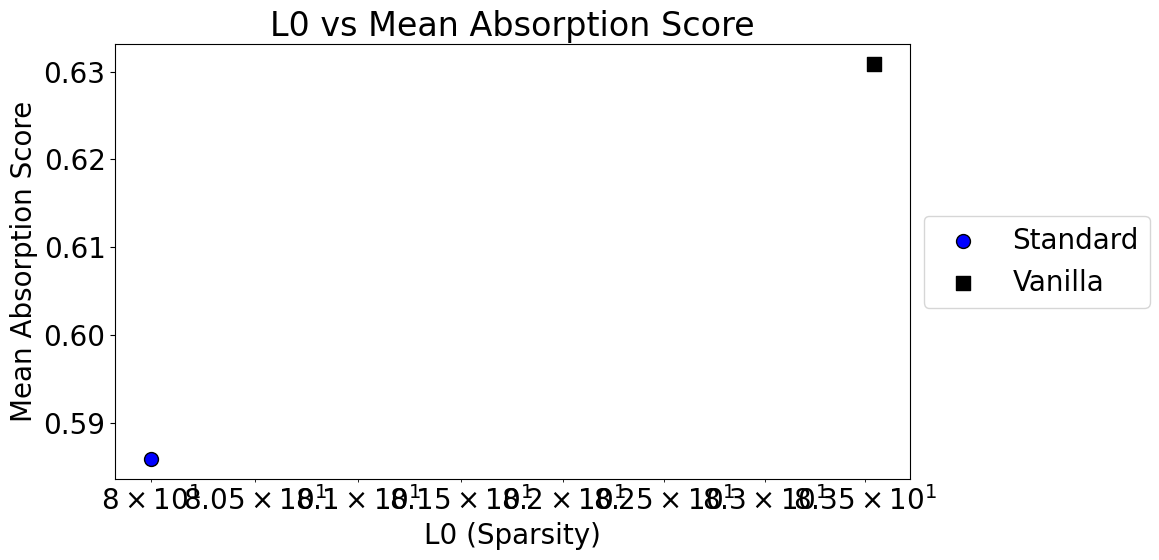

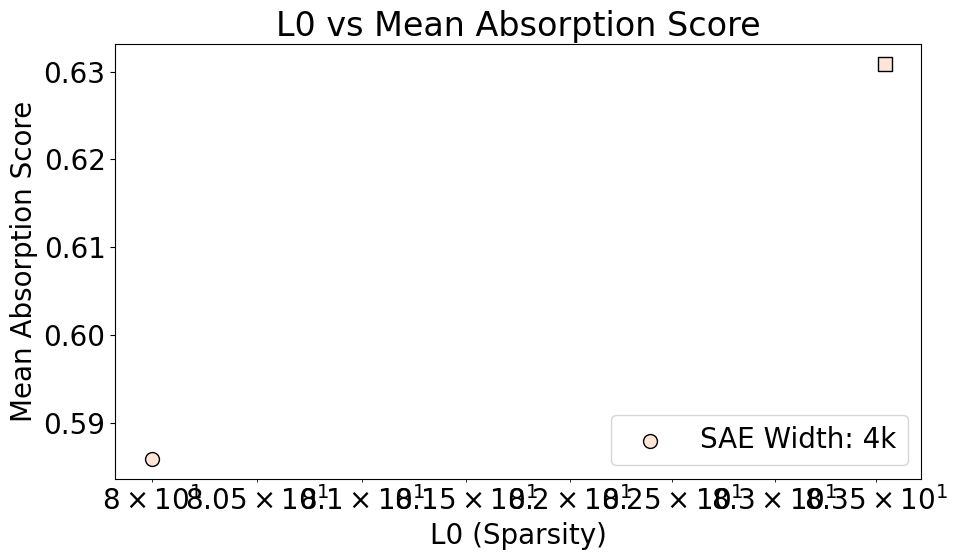

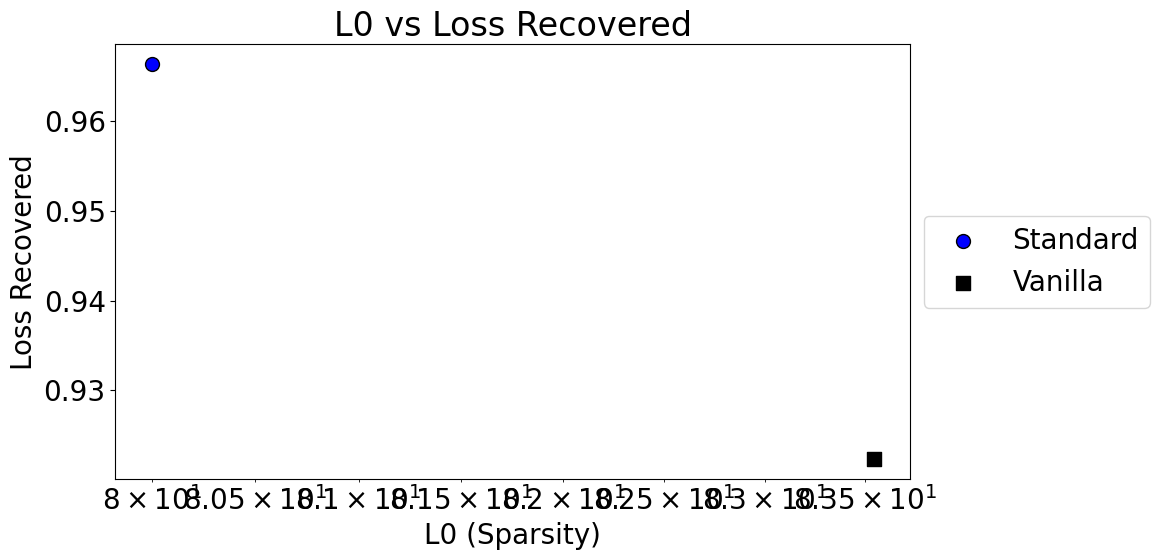

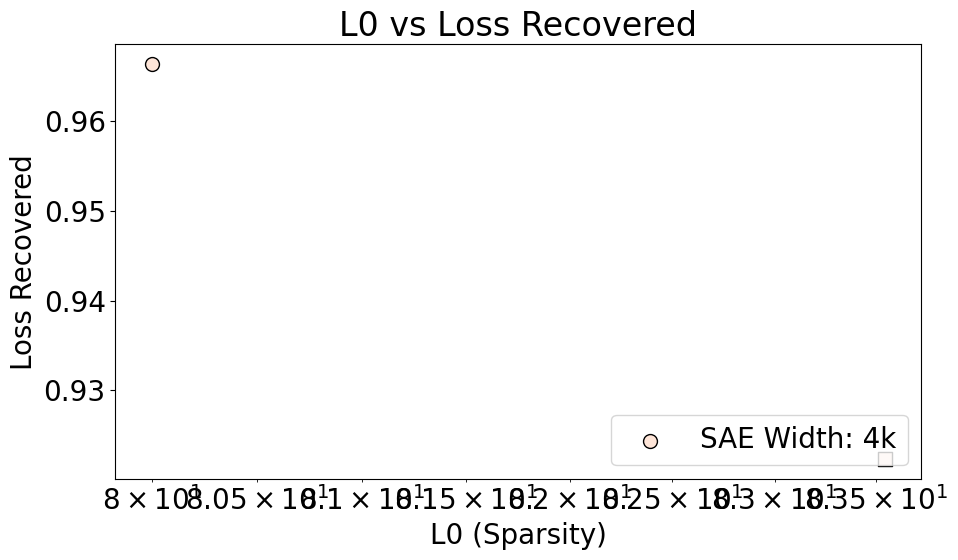

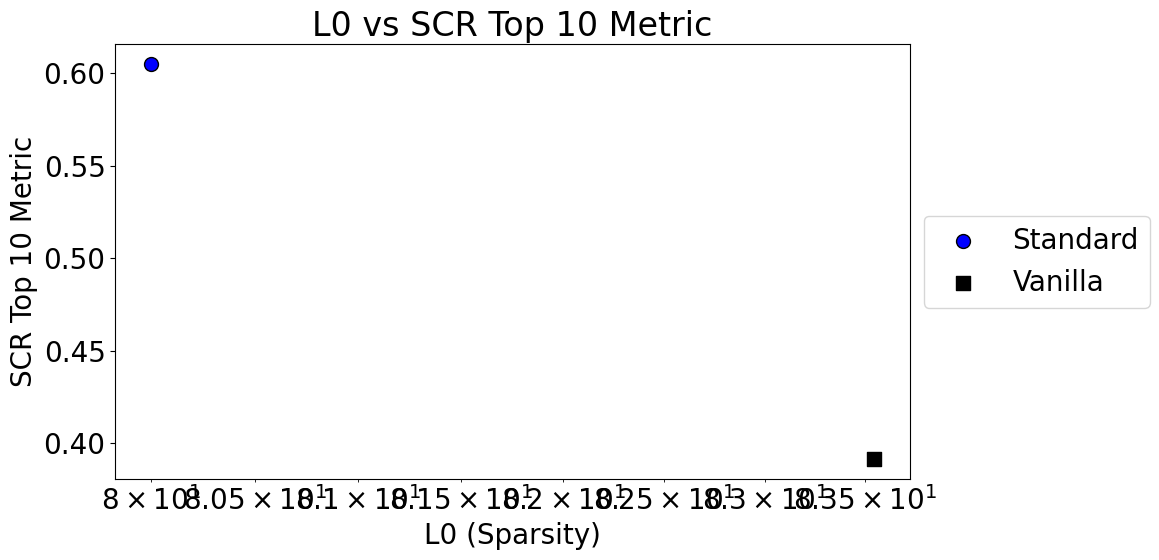

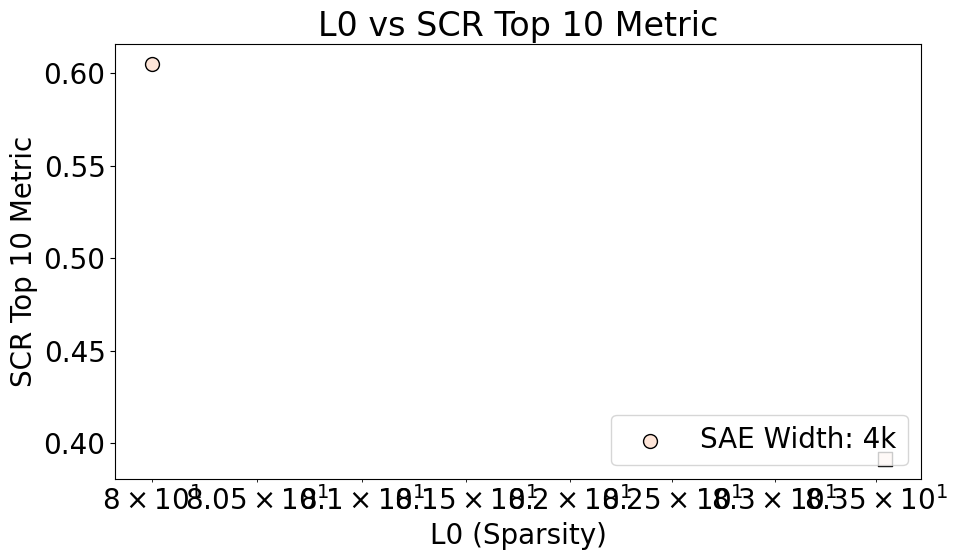

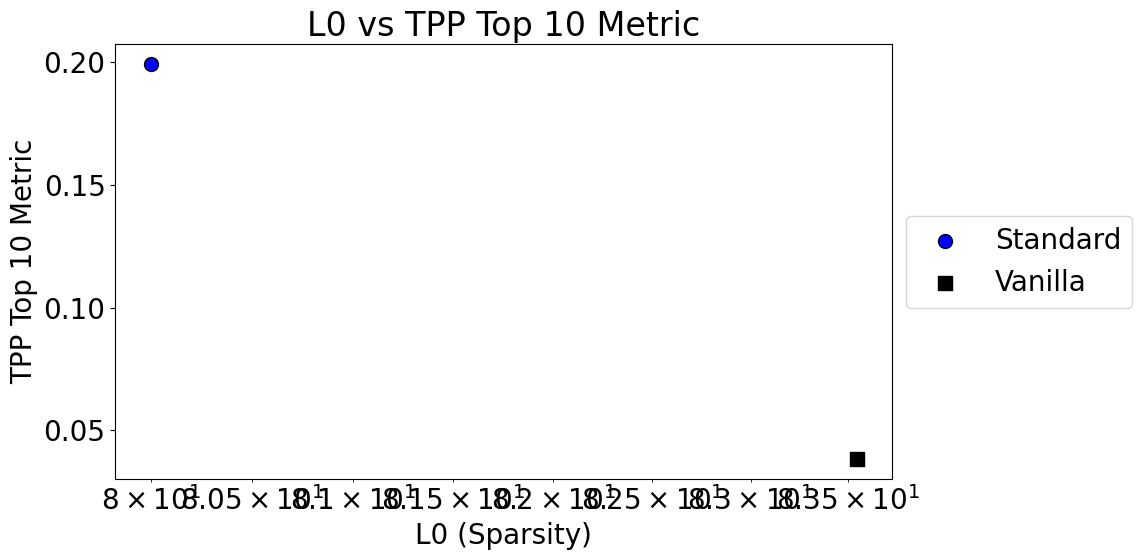

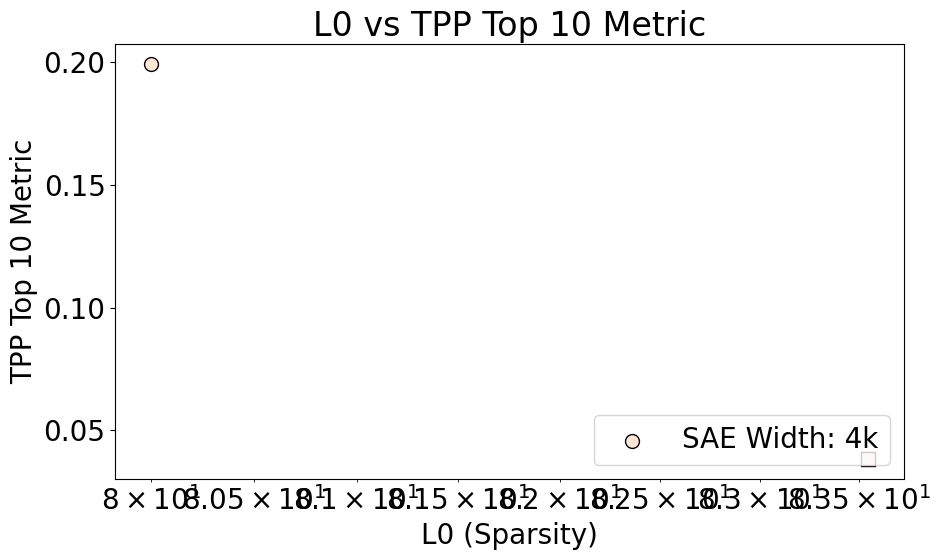

ValueError: Data has no positive values, and therefore cannot be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x738c04132320> (for post_execute), with arguments args (),kwargs {}:


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1200x600 with 1 Axes>

In [18]:
for eval_type in eval_types:
    eval_folders = []

    for results_folder in results_folders:
        eval_folders.append(f"{results_folder}/{eval_type}")

    eval_filenames = graphing_utils.find_eval_results_files(eval_folders)

    graphing_utils.plot_results(
        eval_filenames,
        core_filenames,
        eval_type,
        image_base_name,
        k=10,
        trainer_markers=trainer_markers,
        trainer_colors=trainer_colors,
    )